In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob 
import datetime
import time


In [3]:
file_list = glob.glob("*.csv")
file_list

['2017126-2018327-xrp_news.csv',
 '2016513-2018327-@Ripple.csv',
 'ripple_price_sentiment.csv',
 '2016512-2018327-Ripple_XRP1.csv',
 '20171222-2018327-@Ripple_XRP_News.csv']

In [4]:
x = pd.read_csv('2017126-2018327-xrp_news.csv')

In [15]:
len(x['Tweet Date'][0])

30

In [5]:
def single_CSV_clean(filename):
    
    # read in csv file
    df = pd.read_csv(filename, index_col = 0)
    
    # clean up data frame
    mask = df['Tweet Date'].apply(lambda x: len(str(x)) == 30)
    mask1 = df['Language'] == 'en'
    mask2 = df['Compound'].notnull()
    df = df[mask&mask1&mask2]
    
    # convert Tweet Date to datetime.date object and add to new column
    timelist = []
    for tweet_date in df['Tweet Date']: 
        tweet_datetime = datetime.date(pd.to_datetime(tweet_date))
        timelist.append(tweet_datetime)
    df['Converted_Date'] = timelist
    
    # generate new data frame after groupby & calculation
    cleaned_df = df.groupby('Converted_Date').agg({"Text": "count", "Compound" : "mean"})
    cleaned_df.reset_index(inplace=True)
    
    # split to Tweets data frame and Compound data frame, prepare for merge
    Tweet_df = cleaned_df.drop(labels="Compound", axis=1)
    Tweet_df.columns = [["Converted_Date", df["Account Name"][0]]]
    compound_df = cleaned_df.drop(labels="Text", axis=1)
    compound_df.columns = [["Converted_Date", df["Account Name"][0]]]
    
    return Tweet_df, compound_df



In [6]:
def clean_Group_data(filename):
    x = pd.read_csv(filename)
    mask = x['Tweet Date'].apply(lambda x: len(x) == 30)
    mask1 = x['Language'] == 'en'
    mask2 = x['Compound'].notnull()
    df = x[mask&mask1&mask2]
    timelist = []
    for tweet_date in df['Tweet Date']: 
        tweet_datetime = pd.to_datetime(tweet_date)
        tweet_datetime = str(tweet_datetime)
        unix = time.mktime(datetime.datetime.strptime(tweet_datetime, "%Y-%m-%d %H:%M:%S").timetuple())
        timelist.append(time.strftime('%Y-%m-%d', time.localtime(unix)))
    df['Format_date'] = timelist
    cleaned_data = df.groupby('Format_date').agg({"Compound" : "mean"})
    
    return cleaned_data



In [7]:
file_list = glob.glob("*.csv")
cleanedDataDict = {}
for Datafile in file_list:
    dataFrame = clean_Group_data(Datafile)
    cleanedDataDict[Datafile] = dataFrame
    


/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


KeyError: 'Tweet Date'

In [19]:
file_list

['2017126-2018327-xrp_news.csv',
 '2016513-2018327-@Ripple.csv',
 '2016512-2018327-Ripple_XRP1.csv',
 '20171222-2018327-@Ripple_XRP_News.csv']

In [32]:
ripple = cleanedDataDict['2017126-2018327-xrp_news.csv'].merge(cleanedDataDict['20171222-2018327-@Ripple_XRP_News.csv'], 
                                                       how = "outer", left_index = True, right_index = True).merge(cleanedDataDict['2016513-2018327-@Ripple.csv'], 
                                                       how = "outer", left_index = True, right_index = True).merge(cleanedDataDict['2016512-2018327-Ripple_XRP1.csv'], 
                                                       how = "outer", left_index = True, right_index = True)

In [36]:
ripple['avg compound'] = ripple.mean(axis = 1, skipna = True)

In [39]:
XRP_df = pd.DataFrame(ripple['avg compound'])

In [10]:
price = pd.read_csv("../ripple_price.csv")
btc = pd.read_csv("../btc_usd_datasets.csv")

In [11]:
price["Date"] = pd.to_datetime(price['Date'])
price = price.set_index("Date")


In [12]:
btc['btv_avg'] = btc.mean(axis = 1, skipna = True)
btc["Date"] = pd.to_datetime(btc['Date'])
btc = btc.set_index("Date")

In [13]:
btc = pd.DataFrame(btc.loc['2015-01-01':, :]['btv_avg'])

In [14]:
price['weightedAverage'] = price['weightedAverage']*btc['btv_avg']

In [15]:
ripple_price_sentiment= price.merge(pd.DataFrame(ripple['avg compound']), how = "outer", left_index = True, right_index = True)


NameError: name 'ripple' is not defined

In [17]:
#ripple_price_sentiment.to_csv("ripple_price_sentiment.csv", index=True)
ripple_price_sentiment= pd.read_csv("ripple_price_sentiment.csv")

In [18]:
ripple_price_sentiment1 = ripple_price_sentiment.dropna()
ripple_price_sentiment1.tail()

,Unnamed: 0,close,date,high,low,open,quoteVolume,volume,weightedAverage,avg compound
1149,2018-02-23,0.000093,1.519430e+09,0.000094,0.000091,0.000093,6.743505e+06,622.703817,0.924162,0.039381
1150,2018-02-24,0.000094,1.519517e+09,0.000095,0.000092,0.000093,5.750658e+06,540.029273,0.928929,-0.114400
1151,2018-02-25,0.000090,1.519603e+09,0.000094,0.000089,0.000094,5.759809e+06,529.402173,0.878317,-0.063990
1152,2018-02-26,0.000088,1.519690e+09,0.000091,0.000087,0.000090,7.840411e+06,693.077196,0.886291,0.205602
1153,2018-02-27,0.000086,1.519776e+09,0.000088,0.000080,0.000088,1.754114e+07,1498.860694,0.902613,0.114337


# Visualization

In [19]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
# from matplotlib import style
import time
import glob
from collections import Counter
# style.use('ggplot')
import quandl

from pprint import pprint

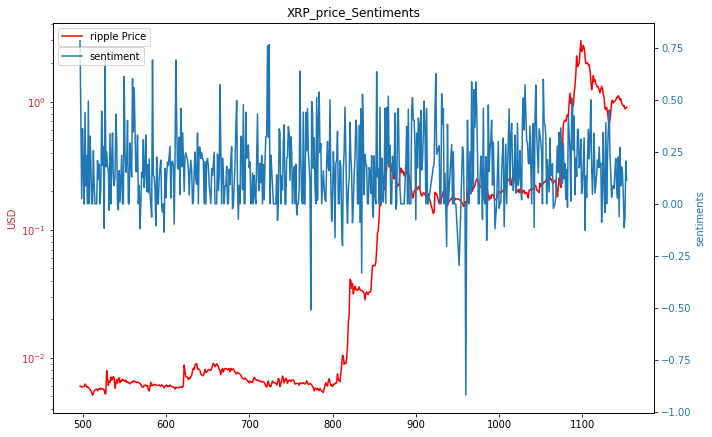

In [22]:
# generate plots, show fig
# some parameters can be adjusted, such as xlim, ylim, ylog, labels
fig, ax1 = plt.subplots(figsize = (10, 6))
color = 'tab:red'
ax1.set_ylabel('USD', color=color)
ax1.plot(ripple_price_sentiment1.index, ripple_price_sentiment1['weightedAverage'], label = "ripple Price", color='red')
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
# ax1.set_ylim(100, 21000)
# ax1.set_ylim(10, 1200)
# ax1.set_ylim(600, 21000)
# ax1.set_ylim(300, 1000)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('sentiments', color=color)
ax2.plot(ripple_price_sentiment1.index, ripple_price_sentiment1["avg compound"], label = "sentiment")
ax2.tick_params(axis='y', labelcolor=color)

ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.95))
#plt.xlim(pd.Timestamp('2013-12-01'), pd.Timestamp('2014-12-01'))
# plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2017-01-01'))
# ax2.set_ylim(-0.5, 0.9)
plt.tight_layout()
# #plt.savefig("Fig01.png")
plt.title("XRP_price_Sentiments")
plt.show()

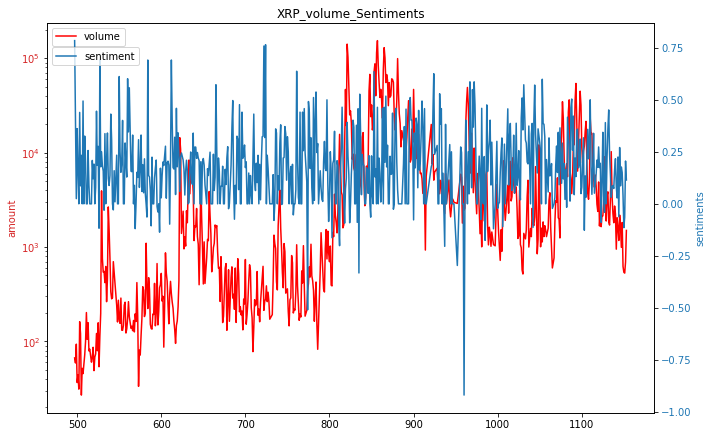

In [24]:
# generate plots, show fig
# some parameters can be adjusted, such as xlim, ylim, ylog, labels
fig, ax1 = plt.subplots(figsize = (10, 6))
color = 'tab:red'
ax1.set_ylabel('amount', color=color)
ax1.plot(ripple_price_sentiment1.index, ripple_price_sentiment1['volume'], label = "volume", color='red')
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
# ax1.set_ylim(100, 21000)
# ax1.set_ylim(10, 1200)
# ax1.set_ylim(600, 21000)
# ax1.set_ylim(300, 1000)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('sentiments', color=color)
ax2.plot(ripple_price_sentiment1.index, ripple_price_sentiment1["avg compound"], label = "sentiment")
ax2.tick_params(axis='y', labelcolor=color)

ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.95))
#plt.xlim(pd.Timestamp('2013-12-01'), pd.Timestamp('2014-12-01'))
# plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2017-01-01'))
# ax2.set_ylim(-0.5, 0.9)
plt.tight_layout()
# #plt.savefig("Fig01.png")
plt.title("XRP_volume_Sentiments")
plt.show()

# Rolling Corr

In [98]:
corr = ripple_price_sentiment1['weightedAverage'].rolling(window=60, min_periods=5).corr(ripple_price_sentiment1["avg compound"])

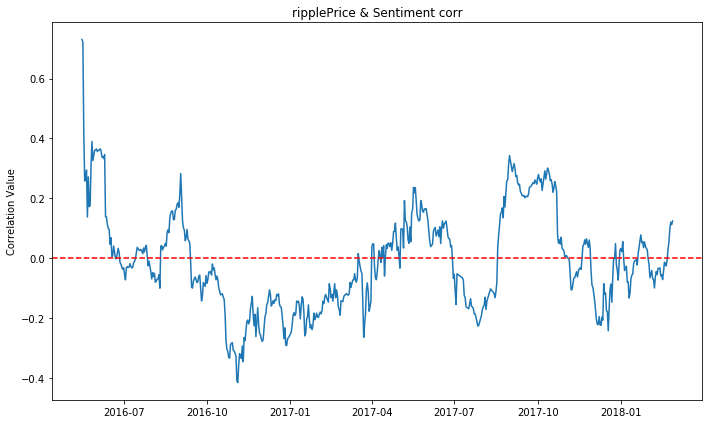

In [100]:
# generate plot to show correlation change
plt.figure(figsize=(10,6))
plt.plot(ripple_price_sentiment1.index, corr)
#plt.xlim(pd.Timestamp('2013-12-01'), pd.Timestamp('2014-12-01'))
# plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2017-01-01'))
plt.axhline(y=0, color='r', linestyle='--')
plt.title("ripplePrice & Sentiment corr")
plt.ylabel("Correlation Value")
plt.savefig("Fig01b.png")
plt.tight_layout()
plt.show()

In [120]:
corr = ripple_price_sentiment1['volume'].rolling(window=60, min_periods=5).corr(ripple_price_sentiment1["avg compound"])

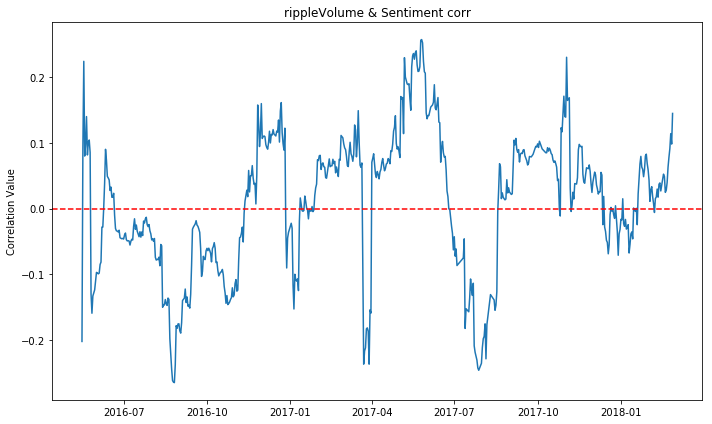

In [122]:
# generate plot to show correlation change
plt.figure(figsize=(10,6))
plt.plot(ripple_price_sentiment1.index, corr)
#plt.xlim(pd.Timestamp('2013-12-01'), pd.Timestamp('2014-12-01'))
# plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2017-01-01'))
plt.axhline(y=0, color='r', linestyle='--')
plt.title("rippleVolume & Sentiment corr")
plt.ylabel("Correlation Value")
plt.savefig("Fig01b.png")
plt.tight_layout()
plt.show()

# Heatmap correlation

In [102]:
import os
import numpy as np
import pandas as pd
import pickle
# pickle to serialize and save the downloaded data as a file, which will prevent our script from re-downloading the same data each time we run the script. 
import quandl
from datetime import datetime
import matplotlib.pyplot as plt
from pprint import pprint
import json
import time
import requests
import json
from pprint import pprint

# We'll also import Plotly and enable the offline mode.

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected = True)



def correlation_heatmap(df, title, absolute_bounds=True):
    '''Plot a correlation heatmap for the entire dataframe'''
    heatmap = go.Heatmap(
        z=df.corr(method='pearson').as_matrix(),
        x=df.columns,
        y=df.columns,
        colorbar=dict(title='Pearson Coefficient'),
    )
    
    layout = go.Layout(title=title)
    
    if absolute_bounds:
        heatmap['zmax'] = 1.0
        heatmap['zmin'] = -1.0
        
    fig = go.Figure(data=[heatmap], layout=layout)
    py.iplot(fig)




In [105]:
Vol_Price_Com= ripple_price_sentiment1[['volume', 'weightedAverage', 'avg compound']]

In [1]:
Vol_Price_Com.head()

NameError: name 'Vol_Price_Com' is not defined

In [118]:
df_2016 = Vol_Price_Com[Vol_Price_Com.index.year == 2016]
df_2016.pct_change().corr(method= 'pearson')

df_2017 = Vol_Price_Com[Vol_Price_Com.index.year == 2017]
df_2017.pct_change().corr(method= 'pearson')


df_2018 = Vol_Price_Com[Vol_Price_Com.index.year == 2018]
df_2018.pct_change().corr(method= 'pearson')





,volume,weightedAverage,avg compound
volume,1.000000,-0.039704,-0.076999
weightedAverage,-0.039704,1.000000,0.114037
avg compound,-0.076999,0.114037,1.000000


In [119]:
correlation_heatmap(df_2016.pct_change().corr(method= 'pearson'), "Correlation_2017")
correlation_heatmap(df_2017.pct_change().corr(method= 'pearson'), "Correlation_2017")
correlation_heatmap(df_2018.pct_change().corr(method= 'pearson'), "Correlation_2018")

### 
1. the corr between ripple avg price and sentiment compound is getting less and less negatively correlated
2. the corr between ripple avg price and volume is getting from positivlt correlated to nagtively coorelated
3. the corr between volume and sentiments is pretty constant in negtively correlated